# 3.8 커스텀 도구(tool)를 최대한 활용하는 방법

- 2.7 병렬 처리를 통한 효율 개선 (feat. 프롬프트 엔지니어링) 에서 작업한 워크플로우를 에이전트로 변환
- 작성했던 노드(node)들을 도구(tool)로 변환하여 사용합니다
    - 도구(tool)는 고정된 기능을 수행하기 때문에 상태(state)를 활용하지 않는 경우가 많음


In [1]:
from dotenv import load_dotenv

load_dotenv()

True

**(중요)**도구(tool)을 활용하려면 [`AIMessage`](https://python.langchain.com/api_reference/core/messages/langchain_core.messages.ai.AIMessage.html)를 활용해야하기 때문에 상태에 `messages`가 필요하다.  

직접 선언하지 않고 랭그래프에서 제공하는 `MessagesState`를 사용해보자.

In [2]:

from langgraph.graph import StateGraph, MessagesState

class AgentState(MessagesState):
    pass

graph_builder = StateGraph(AgentState)

In [3]:
import os 

from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(
    model='text-embedding-3-large',
)
vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name = 'real_estate_tax',
    persist_directory='./real_estate_tax_collection'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [4]:
query = '5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?'

In [5]:
from langchain_openai import ChatOpenAI
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate

rag_prompt = hub.pull('rlm/rag-prompt')

llm = ChatOpenAI(
    model = 'gpt-4o',
)

small_llm = ChatOpenAI(
    model = 'gpt-4o-mini',
)

- [How to create tools](https://python.langchain.com/docs/how_to/custom_tools/)
    - Custom 도구(tool)를 활용하려면 `@tool` decorator를 사용함
    - 도구(tool)의 이름(함수이름)과 설명(docstring)을 정의해야함
    - 도구(tool)의 인자를 정의해야함
        - 인자로 사용되는 변수명도 중요함
        - LLM이 Args를 직접 판단해서 도구를 호출하기 때문
    - 도구(tool)의 반환값을 정의해야함  

In [6]:
# 필요한 라이브러리들을 임포트
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain import hub
from langchain_core.tools import tool
rag_prompt = hub.pull("rlm/rag-prompt")

# 문서 포맷팅을 위한 헬퍼 함수
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# 세금 공제액 정보를 검색하기 위한 체인 구성
tax_deductible_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | rag_prompt
    | small_llm
    | StrOutputParser()
)

# 공제액 관련 기본 질문 정의
deductible_question = f'주택에 대한 종합부동산세 과세표준의 공제액을 알려주세요'

# 사용자별 공제액 계산을 위한 프롬프트 템플릿
user_deduction_prompt = """아래 [Context]는 주택에 대한 종합부동산세의 공제액에 관한 내용입니다. 
사용자의 질문을 통해서 가지고 있는 주택수에 대한 공제액이 얼마인지 금액만 반환해주세요

[Context]
{tax_deductible_response}

[Question]
질문: {question}
답변: 
"""

# 프롬프트 템플릿 객체 생성
user_deduction_prompt_template = PromptTemplate(
    template=user_deduction_prompt,
    input_variables=['tax_deductible_response', 'question']
)

# 사용자별 공제액 계산을 위한 체인 구성
user_deduction_chain = (user_deduction_prompt_template
    | small_llm
    | StrOutputParser()
)

# 세금 공제액 계산을 위한 커스텀 도구
@tool
def tax_deduction_tool(question: str) -> str: # 노드일때는 인자가 state였다. 그런데 노드일때는 question을 인자로 넣는다. 그러면 LLM이 도구를 사용할 때 question에 맞게 질문을 알아서 생성한다.
    """사용자의 부동산 소유 현황에 대한 질문을 기반으로 세금 공제액을 계산합니다.
    
    이 도구는 다음 두 단계로 작동합니다:
    1. tax_deductible_chain을 사용하여 일반적인 세금 공제 규칙을 검색
    2. user_deduction_chain을 사용하여 사용자의 특정 상황에 규칙을 적용

    Args:
        question (str): 부동산 소유에 대한 사용자의 질문
        
    Returns:
        str: 세금 공제액 (예: '9억원', '12억원')
    """
    # 일반적인 세금 공제 규칙 검색
    tax_deductible_response = tax_deductible_chain.invoke(deductible_question)
    
    # 사용자의 특정 상황에 규칙 적용
    tax_deductible = user_deduction_chain.invoke({
        'tax_deductible_response': tax_deductible_response, 
        'question': question
    })
    return tax_deductible

테스트: 도구이니까 invoke를 호출하면 된다.

In [7]:
tax_deduction_tool.invoke(query)

'9억 원입니다.'

### 수학공식을 호출하는 도구

In [8]:
# 사전 구축된 프롬프트를 사용하기 위해 langchain의 hub 모듈을 임포트
from langchain import hub

# hub에서 RAG(Retrieval Augmented Generation) 프롬프트 템플릿을 가져옴
rag_prompt = hub.pull("rlm/rag-prompt")

def format_docs(docs):
    """
    여러 문서를 하나의 문자열로 결합하는 포맷팅 함수
    
    Args:
        docs: page_content를 포함하는 Document 객체 리스트
        
    Returns:
        str: 줄바꿈으로 구분된 문서 내용을 하나로 합친 문자열
    """
    return "\n\n".join(doc.page_content for doc in docs)

# 과세표준 정보를 검색하고 처리하기 위한 체인 생성
# 이 체인은 다음 단계로 실행됨:
# 1. 질문을 받아 관련 문서를 검색
# 2. format_docs를 사용하여 문서 포맷팅
# 3. RAG 프롬프트를 통해 포맷된 컨텍스트와 질문을 처리
# 4. LLM으로 처리 후 문자열로 파싱
tax_base_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | rag_prompt
    | small_llm
    | StrOutputParser()
)

# 과세표준 계산 방법을 검색하기 위한 표준 질문 정의
tax_base_question = '주택에 대한 종합부동산세 과세표준을 계산하는 방법은 무엇인가요? 수식으로 표현해서 수식만 반환해주세요'

# @tool 데코레이터를 사용하여 과세표준 계산을 위한 커스텀 도구 정의
@tool
def tax_base_tool() -> str: # 인자가 없으면 LLM이 인자를 넣지않고 알아서 함수를 호출한다.
    """종합부동산세 과세표준을 계산하기 위한 공식을 검색하고 형식화합니다.
    
    이 도구는 RAG(Retrieval Augmented Generation) 방식을 사용하여:
    1. 지식 베이스에서 과세표준 계산 규칙을 검색
    2. 검색한 규칙을 수학 공식으로 형식화

    Args:
        question (str): 사용자의 질문 (미리 정의된 질문이 사용됨)
        
    Returns:
        str: 과세표준 계산 공식
    """
    # 미리 정의된 질문으로 tax_base_chain을 실행하여 계산 공식 획득
    tax_base_response = tax_base_chain.invoke(tax_base_question)
    return tax_base_response

### 공정시장가액비율 검색 함수

In [9]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from datetime import datetime
from langchain_community.tools import DuckDuckGoSearchRun

# DuckDuckGo 검색 도구 초기화
search = DuckDuckGoSearchRun()

# 현재 공정시장가액비율 검색을 위한 함수
def get_market_value_rate_search():
    """
    현재 연도의 공정시장가액비율을 웹에서 검색합니다.
    
    Returns:
        str: 현재 공정시장가액비율 정보를 포함한 검색 결과
    """
    return search.invoke(f"{datetime.now().year}년도 공정시장가액비율은?")

# 검색 결과 저장
market_value_rate_search = get_market_value_rate_search()

# 공정시장가액비율 추출을 위한 프롬프트 템플릿 정의
# Context에서 관련 정보를 추출하고 사용자 상황에 맞는 비율을 반환하도록 설계
market_value_rate_prompt = PromptTemplate.from_template("""아래 [Context]는 공정시장가액비율에 관한 내용입니다. 
당신에게 주어진 공정시장가액비율에 관한 내용을 기반으로, 사용자의 상황에 대한 공정시장가액비율을 알려주세요.
별도의 설명 없이 공정시장가액비율만 반환해주세요.

[Context]
{context}

[Question]
질문: {question}
답변: 
""")

# 공정시장가액비율 계산을 위한 체인 구성
# 프롬프트 -> LLM -> 문자열 파서 순으로 처리
market_value_rate_chain = (
    market_value_rate_prompt
    | small_llm
    | StrOutputParser()
)

# 공정시장가액비율 계산을 위한 커스텀 도구
@tool
def market_value_rate_tool(question: str) -> str:
    """사용자의 부동산 상황에 적용되는 공정시장가액비율을 결정합니다.
    
    이 도구는:
    1. 현재 공정시장가액비율 정보가 포함된 검색 결과를 사용
    2. 사용자의 특정 상황(보유 부동산 수, 부동산 가치)을 분석
    3. 적절한 공정시장가액비율을 백분율로 반환

    Args:
        question (str): 부동산 소유에 대한 사용자의 질문
        
    Returns:
        str: 공정시장가액비율 백분율 (예: '60%', '45%')
    """
    # 검색된 정보와 사용자 질문을 기반으로 공정시장가액비율 계산
    market_value_rate = market_value_rate_chain.invoke({
        'context': market_value_rate_search, 
        'question': question
    })
    return market_value_rate

/home/sguys99/anaconda3/envs/inflearn-langgraph/lib/python3.12/site-packages/langchain_community/utilities/duckduckgo_search.py:64: UserWarning: 'api' backend is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


### 최종계산

In [10]:
from langchain_core.prompts import ChatPromptTemplate

@tool
def house_tax_tool(tax_base_question: str, market_value_rate_question: str, tax_deductible_question: str, question: str) -> str: 
    # 이 인자들은 도구 실행 결과이므로 ToolMessage에 포함되어 있을 것이다. # LLM이 ToolMessage를 조회해서 인자를 찾아서 알아서 넣는다.
    """수집된 모든 정보를 사용하여 최종 종합부동산세액을 계산합니다.
    
    이 도구는 다음 정보들을 결합하여 최종 세액을 계산합니다:
    1. 과세표준 계산 공식
    2. 공정시장가액비율
    3. 공제액
    4. 세율표

    Args:
        tax_base_question (str): 과세표준 계산 공식
        market_value_rate_question (str): 공정시장가액비율
        tax_deductible_question (str): 공제액
        question (str): 부동산 세금 계산에 대한 사용자의 질문
        
    Returns:
        str: 설명이 포함된 최종 세금 계산액
    """
    # 세금 계산을 위한 프롬프트 템플릿 생성
    # system 메시지에는 계산에 필요한 기본 정보들을 포함
    # human 메시지에는 사용자의 질문을 전달
    house_tax_prompt = ChatPromptTemplate.from_messages([
    ('system', f'''과세표준 계산방법: {tax_base_question}
    공정시장가액비율: {market_value_rate_question}
    공제액: {tax_deductible_question}

    위의 공식과 아래 세율에 관한 정보를 활용해서 세금을 계산해주세요.
    세율: {{tax_rate}}
    '''),
        ('human', '{question}')
    ])

    # 세금 계산을 위한 체인 구성
    # 1. retriever를 통해 세율 정보를 가져옴
    # 2. 프롬프트에 세율 정보와 질문을 전달
    # 3. LLM으로 계산 수행
    # 4. 결과를 문자열로 변환
    house_tax_chain = (
        {
            'tax_rate': retriever | format_docs,  # 벡터 DB에서 세율 정보 검색
            'question': RunnablePassthrough()     # 사용자 질문 그대로 전달
        }
        | house_tax_prompt    # 프롬프트 템플릿에 정보 전달
        | llm                 # LLM으로 계산 수행
        | StrOutputParser()   # 결과를 문자열로 변환
    )

    # 체인 실행하여 최종 세금 계산 결과 반환
    house_tax = house_tax_chain.invoke(question)
    return house_tax

- `node`를 추가하고 `edge`로 연결합니다
- 하나의 `node`에서 `edge`를 활영해서 다양한 `node`들을 연결하면 병렬로 작업이 가능합니다

In [11]:
from langgraph.prebuilt import ToolNode

tool_list = [tax_deduction_tool, tax_base_tool, market_value_rate_tool, house_tax_tool]
llm_with_tools = small_llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

In [12]:
from langchain_core.messages import SystemMessage


def agent(state: MessagesState) -> MessagesState:
    """
    에이전트 함수는 주어진 상태에서 메시지를 가져와
    LLM과 도구를 사용하여 응답 메시지를 생성합니다.

    Args:
        state (MessagesState): 메시지 상태를 포함하는 state.

    Returns:
        MessagesState: 응답 메시지를 포함하는 새로운 state.
    """
    system_message_content = """당신의 역할은 주택에 대한 종합부동산세를 계산하는 것입니다. 
    사용자의 질문이 들어오면, 사용자의 질문을 바탕으로 종합부동산세를 계산해주세요.
    종합부동산세를 계산하기 위해서는 과세표준을 어떻게 계산할지 파악해야하고, 
    사용자에 질문에 따른 공제액을 파악해야 하고, 
    사용자에 질문에 따른 공정시장가액비율을 파악해야 합니다.
    이 세가지를 파악하고 나면, 종합부동산세를 계산해주세요.
    """
    system_message = SystemMessage(content=system_message_content)
    messages = [system_message] + state['messages']
    response = llm_with_tools.invoke(messages)
    return {'messages': [response]}

In [13]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)

In [14]:
from langgraph.graph import START, END
from langgraph.prebuilt import tools_condition


graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    tools_condition
)
graph_builder.add_edge('tools', 'agent')

In [15]:
graph = graph_builder.compile()

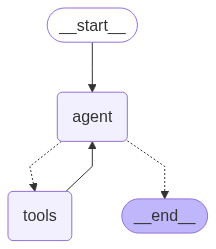

In [16]:
graph

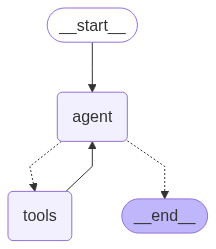

In [17]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
from langchain_core.messages import HumanMessage

for chunk in graph.stream({'messages': [HumanMessage(query)]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?
================================== Ai Message ==================================
Tool Calls:
  tax_deduction_tool (call_CQHIWJQxQ3IroSf35S4sjSmK)
 Call ID: call_CQHIWJQxQ3IroSf35S4sjSmK
  Args:
    question: 5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금 공제액은 얼마인가요?
  tax_base_tool (call_HsDJCHhTvAyFx7etsbXK2zSP)
 Call ID: call_HsDJCHhTvAyFx7etsbXK2zSP
  Args:
  market_value_rate_tool (call_m51Y3oAV58GKpJ6E3Dhj73ua)
 Call ID: call_m51Y3oAV58GKpJ6E3Dhj73ua
  Args:
    question: 5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 공정시장가액비율은 얼마인가요?
================================= Tool Message =================================
Name: market_value_rate_tool

45%
================================== Ai Message ==================================
Tool Calls:
  house_tax_tool (call_LFI3bc8hkmCiCz5dJJcCPc9Q)
 Call ID: call_LFI3bc8hkmCiCz5dJJcCPc9Q
  Args:
    tax_base_